# Laplace 1D - Bootstrap on a Fixed Domain Size

## Goal
Given the Laplace operator $A = -\Delta$, find **test functions** $x$ of unit $l_2$ norm with small $\|A x\|$; i.e., near-null-space components, on a periodic domain, with constant $k$.

To this end, we generate test functions that approximately solve $A x = \lambda x$, where $\lambda$ is the minimum eigenvalue.

## Discretization
We use the 3-point finite difference $A^h = [1, -2, 1]$. In this experiment we use a fixed periodic domain with $n=16$ points.

In [344]:
import logging
import numpy as np
import helmholtz as hm
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics.pairwise
import sys
from numpy.ma.testutils import assert_array_almost_equal
from numpy.linalg import eig, norm

np.random.seed(1)

%load_ext autoreload
%autoreload 2

np.set_printoptions(linewidth=500, precision=2, suppress=False)
for handler in logging.root.handlers[:]: logging.root.removeHandler(handler)
logging.basicConfig(stream=sys.stdout, level=logging.DEBUG, format="%(levelname)-8s %(message)s",
                    datefmt="%a, %d %b %Y %H:%M:%S")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1-Level

### Exact Eigenpairs
There are 3 positive eigenvalues, corresponding to the constant, left wave and right wave. $\lambda_1$ happens to be a double eigenvalue. We will be attempting to find it and its corresponding eigenvectors $v_1, v_2$ (or combinations of them). 

In [345]:
def exact_eigenpair(a):
    """Returns the exact eigenpairs (v, lam) ((v[:, i], lam[i]) is the ith pair), sorted by
    ascending|lam| value."""
    lam, v = eig(a.toarray())
    lam = np.real(lam)
    ind = np.argsort(np.abs(lam))
    lam = lam[ind]
    return v[:, ind], lam

In [346]:
n = 16
kh = 0
a = hm.linalg.helmholtz_1d_operator(kh, n)
print("A in some window")
print(a.toarray()[:5,:5])

A in some window
[[-2.  1.  0.  0.  0.]
 [ 1. -2.  1.  0.  0.]
 [ 0.  1. -2.  1.  0.]
 [ 0.  0.  1. -2.  1.]
 [ 0.  0.  0.  1. -2.]]


In [347]:
v, lam = exact_eigenpair(a)
pd.DataFrame(lam)

,0
0,3.608225e-16
1,-1.522409e-01
2,-1.522409e-01
3,-5.857864e-01
4,-5.857864e-01
5,-1.234633e+00
6,-1.234633e+00
7,-2.000000e+00
8,-2.000000e+00
9,-2.765367e+00


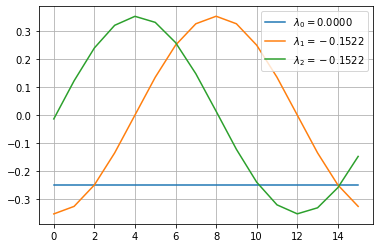

In [348]:
for i in range(3):
    plt.plot(v[:, i], label="$\lambda_{} = {:.4f}$".format(i, lam[i]))
plt.legend();
plt.grid(True);

## 1-Level Method: Relaxed Test Functions
To generate $K$ examples (i.e., a test matrix $x_{n \times K}$), we start from $x \longleftarrow rand[-1,1]$, and perform relaxations for $A x=0$.

In [349]:
level =helmholtz.setup.multilevel.Level.create_finest_level(a)
multilevel =helmholtz.setup.multilevel.Multilevel(level)

In [350]:
# Run enough Kaczmarz relaxations per lambda update (not just 1 relaxation) so we converge to the minimal one.
num_iters = 1
num_examples = 4
logger = logging.getLogger("multilevel")
logger.setLevel(logging.DEBUG)

x_relax = {}
nu_values = (1, 5, 10, 20)
for nu in nu_values:
    x = helmholtz.solve.run.random_test_matrix((n,), num_examples=num_examples)
    print("nu {}".format(nu))
    method = lambda x: hm.solve.relax_cycle.relax_cycle(multilevel, 1.0, None, None, nu).run(x)
    x, conv_factor = helmholtz.solve.run.run_iterative_method(level.operator, method, x, num_iters, print_frequency=1)
    x_relax[nu] = x

nu 1
DEBUG        0 |r| 1.29228543e+00 RER 2.51134
DEBUG        1 |r| 1.58543692e+00 (1.22685) RER 1.58544 (0.63131) 1.00000
nu 5
DEBUG        0 |r| 1.80013604e+00 RER 3.21212
DEBUG        1 |r| 4.17038566e-01 (0.23167) RER 0.41704 (0.12983) 1.00000
nu 10
DEBUG        0 |r| 8.50633626e-01 RER 2.21106
DEBUG        1 |r| 3.07261643e-01 (0.36122) RER 0.30726 (0.13897) 1.00000
nu 20
DEBUG        0 |r| 1.40399886e+00 RER 2.65860
DEBUG        1 |r| 1.95266309e-01 (0.13908) RER 0.19527 (0.07345) 1.00000


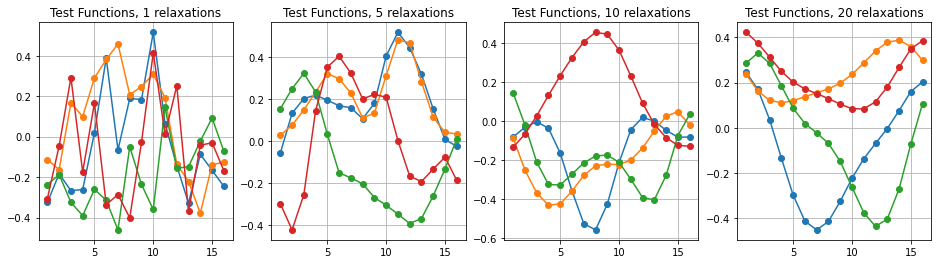

In [351]:
fig, axs = plt.subplots(1, len(nu_values), figsize=(16, 4))

gridpoint = np.arange(1, n+1)
for i, nu in enumerate(nu_values):
    ax = axs[i]
    for m in range(4):
        ax.plot(gridpoint, x_relax[nu][:, m], '-o')
    ax.grid(True);
    ax.set_title("Test Functions, {} relaxations".format(nu));
#plt.savefig("/Users/olivne/Desktop/test_functions.png")

It turns out that $\nu$ must be sufficiently large ($100$) to guarantee convergence to the smallest eigenvalue, and even then it depends on the initial guess. This is perhaps because Kaczmarz is a slow relaxation, but more likely because a random initial guess is not good enough. 

Perhaps that's OK; for bootstrapping, we need the initial vectors to be smooth enough, but not necessarily the exact lowest eigenvector.

## Coarsening
We use test vectors created by $\nu=20$ relaxations.

### Restriction: SVD on Window (Aggregate)
Starting from an aggregate of size $w=2$, we use $4w$ windows from the relaxed vectors, and calculate the SVD of the window test matrix ($4w \times w$). The rows of the restriction $R$ are the $n_c$ principal components that guarantee $10\%$ reconstruction error. If $n_c/w$ is not small enough, we double the window size until $n_c/w < 0.5$.

In [352]:
# Say, take vectors that passed 10 relaxations.
nu = 20
x = x_relax[nu]

l = 1
print("Coarsening level {}->{}".format(l - 1, l))
domain_size = level.a.shape[0]
threshold = 0.1
caliber = 2
interpolation_method = "svd"
r, p, s = helmholtz.repetitive.bootstrap_repetitive.create_transfer_operators(
    x, domain_size, threshold=threshold, caliber=caliber,
    interpolation_method=interpolation_method)

Coarsening level 0->1
DEBUG    SVD  8 x  2 nc 2 cr 1.00 error 0.000 Singular vals [1.08, 0.12] error [0.11, 0.  ]
DEBUG    SVD 16 x  4 nc 2 cr 0.50 error 0.067 Singular vals [1.64, 0.73, 0.12, 0.01] error [0.41, 0.07, 0.01, 0.  ]


In [353]:
r.asarray()

array([[-0.54, -0.53, -0.49, -0.43],
       [ 0.63,  0.18, -0.3 , -0.69]])

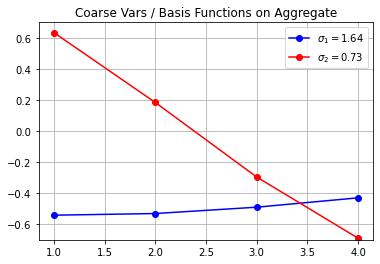

In [354]:
colors = ["b", "r", "g"]
rr = r.asarray()
aggregate_size = rr.shape[1]
for i in range(rr.shape[0]):
    color = colors[i % len(colors)]
    plt.plot(np.arange(1, aggregate_size + 1), rr[i], '{}o-'.format(color), 
             label="$\sigma_{" + str(i+1) + "} = " + "{:.2f}".format(s[i]) + "$")
plt.ylim([-0.7, 0.7]);
plt.legend(loc="upper right");
plt.grid(True);
plt.title("Coarse Vars / Basis Functions on Aggregate");

For the Laplace case, we expect only one large singular value and thus $w = 2, n_c = 1$, but here we actually observe that in the $2$-point window, one coarse variable results in a $20\%$ reconstruction error.

Thus we go into $4$-point window and find two coarse variables, corresponding to the constant and linear basis functions.

### Interpolation

#### Choice 1: SVD-based $P = R^T$.
This is what we use here. However, this is already not the natural geometric interpolation, because of the linear basis function in $R$.

#### Choice 2: fitted by least-squares.

### Coarse Operator

In [355]:
level =helmholtz.setup.multilevel.Level.create_coarse_level(level.a, level.b, r, p)
multilevel.level.append(level)

4 4 16
[ 0  0  1  1  2  2  3  3  4  4  5  5  6  6  7  7  8  8  9  9 10 10 11 11 12 12 13 13 14 14 15 15]
[0 1 0 1 0 1 0 1 2 3 2 3 2 3 2 3 4 5 4 5 4 5 4 5 6 7 6 7 6 7 6 7]
[-0.54  0.63 -0.53  0.18 -0.49 -0.3  -0.43 -0.69 -0.54  0.63 -0.53  0.18 -0.49 -0.3  -0.43 -0.69 -0.54  0.63 -0.53  0.18 -0.49 -0.3  -0.43 -0.69 -0.54  0.63 -0.53  0.18 -0.49 -0.3  -0.43 -0.69]


In [356]:
level.print()

INFO     a = 
[[-0.48  0.1   0.23 -0.27  0.    0.    0.23  0.37]
 [ 0.1  -1.47  0.37 -0.44  0.    0.   -0.27 -0.44]
 [ 0.23  0.37 -0.48  0.1   0.23 -0.27  0.    0.  ]
 [-0.27 -0.44  0.1  -1.47  0.37 -0.44  0.    0.  ]
 [ 0.    0.    0.23  0.37 -0.48  0.1   0.23 -0.27]
 [ 0.    0.   -0.27 -0.44  0.1  -1.47  0.37 -0.44]
 [ 0.23 -0.27  0.    0.    0.23  0.37 -0.48  0.1 ]
 [ 0.37 -0.44  0.    0.   -0.27 -0.44  0.1  -1.47]]
INFO     r = 
[[-0.54 -0.53 -0.49 -0.43]
 [ 0.63  0.18 -0.3  -0.69]]
INFO     p = 
(array([[0, 1],
       [0, 1],
       [0, 1],
       [0, 1]]), array([[-0.54,  0.63],
       [-0.53,  0.18],
       [-0.49, -0.3 ],
       [-0.43, -0.69]]))


## 2-level Bootstrap
Improve the test functions with a 2-level relaxation cycle. We use a Cycle(2, 2; 4) (2 pre-, 2 post- and 4 on the coarse level), which is eqeuivalent to 6 fine level relaxations' work.

In [357]:
num_iters = 10
def relax_cycle(x):
     return hm.solve.relax_cycle.relax_cycle(multilevel, 1.0, 2, 2, 4).run(x)

level = multilevel.level[0]
x_2level, conv_factor = helmholtz.solve.run.run_iterative_method(level.operator, relax_cycle, x, num_iters, print_frequency=1)

DEBUG        0 |r| 1.95266309e-01 RER 0.19527
DEBUG        1 |r| 1.96293401e-01 (1.00526) RER 0.19629 (1.00526) 1.00000
DEBUG        2 |r| 1.78134120e-01 (0.90749) RER 0.17813 (0.90749) 1.00000
DEBUG        3 |r| 1.61951090e-01 (0.90915) RER 0.16195 (0.90915) 1.00000
DEBUG        4 |r| 1.45498517e-01 (0.89841) RER 0.14550 (0.89841) 1.00000
DEBUG        5 |r| 1.28175917e-01 (0.88094) RER 0.12818 (0.88094) 1.00000
DEBUG        6 |r| 1.10589497e-01 (0.86279) RER 0.11059 (0.86279) 1.00000
DEBUG        7 |r| 9.36629869e-02 (0.84694) RER 0.09366 (0.84694) 1.00000
DEBUG        8 |r| 7.81510771e-02 (0.83439) RER 0.07815 (0.83439) 1.00000
DEBUG        9 |r| 6.44766618e-02 (0.82503) RER 0.06448 (0.82503) 1.00000
DEBUG       10 |r| 5.27625579e-02 (0.81832) RER 0.05276 (0.81832) 1.00000


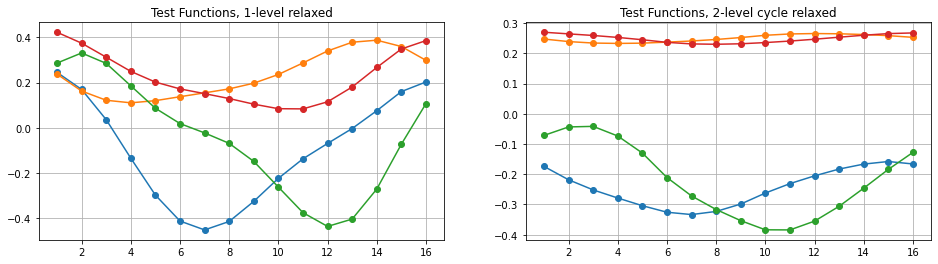

In [358]:
fig, axs = plt.subplots(1, 2, figsize=(16, 4))

gridpoint = np.arange(1, n+1)

ax = axs[0]
for m in range(4):
    ax.plot(gridpoint, x[:, m], '-o')
ax.grid(True);
ax.set_title("Test Functions, 1-level relaxed")

ax = axs[1]
for m in range(4):
    ax.plot(gridpoint, x_2level[:, m], '-o')
ax.grid(True);
ax.set_title("Test Functions, 2-level cycle relaxed");

The improved coarse vectors have a much lower RER. The cycle is more efficient than relaxation in reducing the RER.

In [359]:
conv_factor ** (1/6)

0.9708466734888751

### Refit coarsening

In [365]:
# Say, take vectors that passed 10 relaxations.
x = x_2level

l = 1
print("Coarsening level {}->{}".format(l - 1, l))
domain_size = level.a.shape[0]
threshold = 0.1
caliber = 2
interpolation_method = "svd"
r, p, s = helmholtz.repetitive.bootstrap_repetitive.create_transfer_operators(
    x, domain_size, threshold=threshold, caliber=caliber,
    interpolation_method=interpolation_method)

Coarsening level 0->1
DEBUG    SVD  8 x  2 nc 1 cr 0.50 error 0.052 Singular vals [0.84, 0.04] error [0.05, 0.  ]


In [367]:
r.asarray()

array([[0.7 , 0.72]])

In [370]:
p.asarray()

(array([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]]),
 array([[0.7 ],
        [0.72]]))

With these vectors, we see only one principcal component.

In [363]:
level = multilevel.level[0]
coarse_level =helmholtz.setup.multilevel.Level.create_coarse_level(level.a, level.b, r, p)
coarse_level.print()

[[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]]
[[0.7 ]
 [0.72]]
8 8 64
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7]
[0.7  0.72 0.7  0.72 0.7  0.72 0.7  0.72 0.7  0.72 0.7  0.72 0.7  0.72 0.7  0.72]


ValueError: row, column, and data array must all be the same length